In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import data_providing as dp

In [68]:
# Download data and get a path to where it's downloaded
PATH_DATA = dp.fetch_product_classification_data()
PATH_TRAIN = os.path.join(PATH_DATA, 'train')
PATH_TEST = os.path.join(PATH_DATA, 'test')

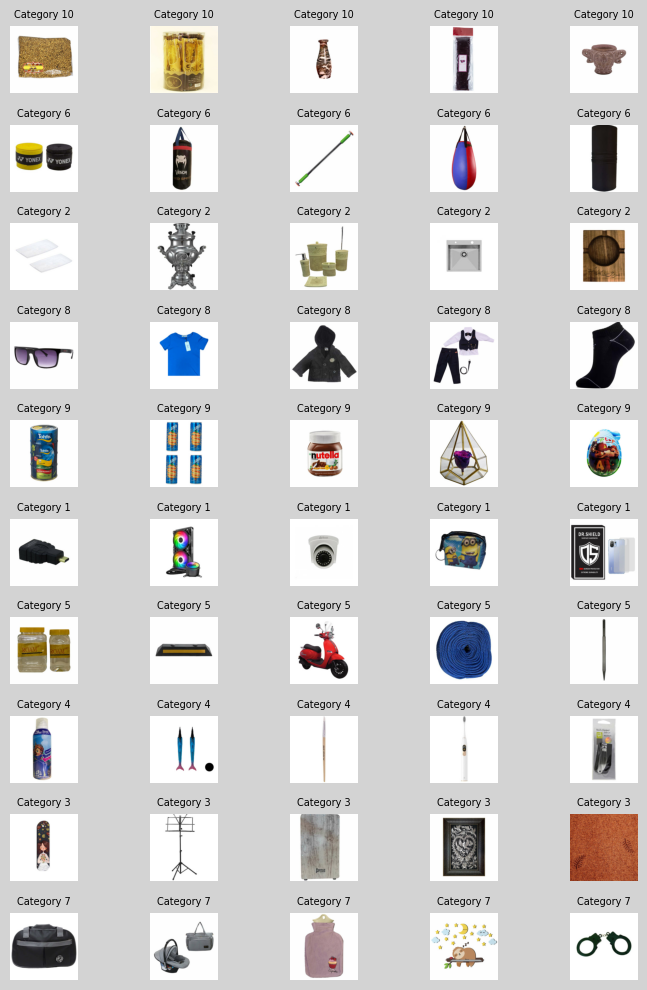

In [82]:
# Let's show some samples from dataset
ns = 5 # number of samples for each class
nc = 10 # number of classes
fig, axes = plt.subplots(nc, ns, figsize=(ns * 1.5, nc))
np.random.seed(42)

for i, dir in enumerate(os.listdir(PATH_TRAIN)):
  path_dir = os.path.join(PATH_TRAIN, dir)
  file_names = os.listdir(os.path.join(PATH_TRAIN, dir))
  file_names_selected = np.random.choice(file_names, ns, replace=False)
  for j, _ in enumerate(file_names_selected):
    name_file = file_names_selected[j]
    path_file = os.path.join(path_dir, name_file)
    image_file = tf.io.read_file(path_file)
    image = tf.image.decode_image(image_file, channels=3)
    axes[i, j].imshow(image / 255)
    axes[i, j].axis('off')
    title = axes[i, j].set_title(f'Category {dir}')
    title.set_fontsize(7)

fig.set_facecolor('lightgray')
plt.tight_layout()
plt.show()

In [86]:
# Define a data generator for data augmentation to avoid overfitting
train_datagen = ImageDataGenerator(
        rescale=1/255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

# Obviously, this one only reads test dataset and doesn't augmentate it
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [88]:
batch_size = 32
image_size = (456, 456)

# train_generator is responsible for loading and augmentating train data
# while training the model
train_generator = train_datagen.flow_from_directory(
    directory=PATH_TRAIN,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# valid_generator is responsible for loading and augmentating validation data
# while training the model
valid_generator = train_datagen.flow_from_directory(
    directory=PATH_TRAIN,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

# test_genrator is responsible for loading test data
test_generator = test_datagen.flow_from_directory(
    directory=PATH_TEST,
    target_size=image_size,
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 7994 images belonging to 10 classes.
Found 1996 images belonging to 10 classes.
Found 4000 images belonging to 1 classes.
